# Find out the best neighborhood  to open a Chinese restaurant in Toronto


### Introduction
One of my friends and her husband live in Toronto. They want to do some investments. They prefer to start a small business, because they don't want invest too much money. They all love food and have good cooking skills for Chinese foods. It seems like that opening a Chinese restaurant is a good idea for them.    
Location is extremely important for opening a restaurant. But Toronto is so big that investigating all the neighborhoods is time consuming and expensive. It’s not possible to investigate all of them on site.  
The purpose of my job is to find out some neighborhoods that have the potential to be a good choice, so that can reduce their workloads.


### Data Collection
Demographics Information for neighborhoods in Toronto comes from website. I decide to scrape data from [Wikipedia page](https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods)   

Geographic information comes from package ‘geopy.geocoders’, I use neighborhoods' name to find their latitude and longitude.  

Venues’ information is from Foursquare. The required data is as follows:  
    1. Chinese restaurants information in each neighborhood  
    2. Total restaurants information in each neighborhood  
    3. Information about all venues in each neighborhood
    4. Population Density for each neighborhood


### Methodology
There are three main factors for location selecting.     
First, the neighborhood must have a large population density. It's very straightforward that larger population density means more potential customers. I will scrape population from Wikipedia page (https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods)    
Second, the neighborhood needs to have strong commercial atmosphere. I will use the amount of total venues within 1000 meters radius of each neighborhood to represent business atmosphere. The higher the amount, the stronger the atmosphere.    
Third, there can't be too many competitors in the neighborhood. I will use ratio of the number of Chinese restaurants over the amount of total restaurant. If the ratio is small, the competition in that neighborhood might be small.     
After getting all the information I need, I will do a clustering to classify all the neighborhoods. Then, I’ll find out which cluster has high population density, strong commercial atmosphere, low competition. Neighborhoods in this cluster are the candidate for on-site investigation.



### Data Exploratory 

#### Scrape Geographic Information from [Wikipedia page](https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods)

In [1]:
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
from bs4 import BeautifulSoup
import requests
import lxml
print('Libraries imported')

Libraries imported


In [2]:
# Wikipedia page
wiki_link_demo = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
wiki_tor_demo = requests.get(wiki_link_demo).text

In [3]:
soup_tor_demo = BeautifulSoup(wiki_tor_demo, 'lxml')
table_demo = soup_tor_demo.find('table', class_='wikitable sortable').text

In [4]:
table_demo_list =table_demo.split('\n\n\n\n\n')

In [5]:
# delete the first row which is column names
table_demo_list.pop(0)

'\n\nName\n\nFM\n\nCensus Tracts\n\nPopulation\n\nLand area (km2)\n\nDensity (people/km2)\n\n% Change in Population since 2001\n\nAverage Income\n\nTransit Commuting\xa0%\n\n% Renters\n\nSecond most common language (after English) by name\n\nSecond most common language (after English) by percentage\n\nMap\n\n\nToronto CMA Average\n\n\n\nAll\n\n5,113,149\n\n5903.63\n\n866\n\n9.0\n\n40,704\n\n10.6\n\n11.4'

In [6]:
#change the format of the first line
table_demo_list[0]='Agincourt\n\nS\n\n0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0378.08, 0378.14, 0378.23, 0378.24\n\n44,577\n\n12.45\n\n3580\n\n4.6\n\n25,750\n\n11.1\n\n5.9\n\nCantonese (19.3%)\n\n19.3% Cantonese'

In [7]:
table_list = []
for l in table_demo_list:
    l_d = {}
    l_d = l.split('\n\n')
    table_list.append(l_d)
table_demo_df = pd.DataFrame(table_list)
table_demo_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...","44,577",12.45,3580,4.6,"25,750",11.1,5.9,Cantonese (19.3%),19.3% Cantonese,None
1,Alderwood,E,"0211.00, 0212.00","11,656",4.94,2360,-4.0,"35,239",8.8,8.5,Polish (6.2%),06.2% Polish,None
2,Alexandra Park,OCoT,0039.00,"4,355",0.32,"13,609",0.0,"19,687",13.8,28.0,Cantonese (17.9%),17.9% Cantonese,None
3,Allenby,OCoT,0140.00,"2,513",0.58,4333,-1.0,"245,592",5.2,3.4,Russian (1.4%),01.4% Russian,None
4,Amesbury,NY,"0280.00, 0281.01, 0281.02","17,318",3.51,"4,934",1.1,"27,546",16.4,19.7,Spanish (6.1%),06.1% Spanish,None


In [8]:
table_demo_df = table_demo_df.iloc[:,[0, 3, 5, 7, 9]]
table_demo_df.columns = ['Neighborhood', 'Population', 'Density(people/km2)', 'Average Income', 'Percent of Renters']
table_demo_df.head()

,Neighborhood,Population,Density(people/km2),Average Income,Percent of Renters
0,Agincourt,"44,577",3580,"25,750",5.9
1,Alderwood,"11,656",2360,"35,239",8.5
2,Alexandra Park,"4,355","13,609","19,687",28.0
3,Allenby,"2,513",4333,"245,592",3.4
4,Amesbury,"17,318","4,934","27,546",19.7


In [9]:
table_demo_df.shape

(174, 5)

In [10]:
#Check if the dataset have missing value
print('Number of missing values: \n{}'.format(table_demo_df.isnull().sum()))

Number of missing values: 
Neighborhood           0
Population             0
Density(people/km2)    0
Average Income         0
Percent of Renters     0
dtype: int64


In [11]:
table_demo_df['Neighborhood'][0]

'Agincourt'

In [12]:
address = '{}, Toronto'.format(table_demo_df['Neighborhood'][0])
print(address)

Agincourt, Toronto


In [13]:
sLength = len(table_demo_df['Neighborhood'])
table_demo_df = table_demo_df.assign(Latitude=pd.Series(np.random.randn(sLength)).values)
table_demo_df = table_demo_df.assign(Longitude=pd.Series(np.random.randn(sLength)).values)
table_demo_df.head()

,Neighborhood,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude
0,Agincourt,"44,577",3580,"25,750",5.9,0.716789,1.523701
1,Alderwood,"11,656",2360,"35,239",8.5,-0.102850,-1.354758
2,Alexandra Park,"4,355","13,609","19,687",28.0,1.855245,-1.995857
3,Allenby,"2,513",4333,"245,592",3.4,-0.258946,-0.575546
4,Amesbury,"17,318","4,934","27,546",19.7,-0.699511,1.280356


In [14]:
sLength

174

In [15]:
# Add geographic information to each Neighborhood
no_geo = []
for i in range(sLength):
    address = '{}, Toronto'.format(table_demo_df['Neighborhood'][i])
    print(address)
    geolocator = Nominatim(user_agent="ny_explorer")
    try:
        location = geolocator.geocode(address)
        table_demo_df['Latitude'][i] = location.latitude
        table_demo_df['Longitude'][i] = location.longitude
    except:
        no_geo.append(address)

Agincourt, Toronto


C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Alderwood, Toronto
Alexandra Park, Toronto
Allenby, Toronto
Amesbury, Toronto
Armour Heights, Toronto
Banbury, Toronto
Bathurst Manor, Toronto
Bay Street Corridor, Toronto
Bayview Village, Toronto
Bayview Woods – Steeles, Toronto
Bedford Park, Toronto
Bendale, Toronto
Birch Cliff, Toronto
Bloor West Village, Toronto
Bracondale Hill, Toronto
Branson, Toronto
Bridle Path, Toronto
Brockton, Toronto
Cabbagetown, Toronto
Caribou Park, Toronto
Carleton Village, Toronto
Casa Loma, Toronto
Centennial, Toronto
Chaplin Estates, Toronto
Christie Pits, Toronto
Church and Wellesley, Toronto
Clairville, Toronto
Clairlea, Toronto
Cliffcrest, Toronto
Cliffside, Toronto
Corktown, Toronto
Crescent Town, Toronto
Cricket Club, Toronto
Davenport, Toronto
Davisville, Toronto
Deer Park, Toronto
Discovery District, Toronto
Distillery District/West Don Lands, Toronto
Don Mills, Toronto
Don Valley Village, Toronto
Dorset Park, Toronto
Dovercourt Park, Toronto
Downsview, Toronto
Dufferin Grove, Toronto
Earlscour

In [16]:
## See how many neighborhoods do not get geographic information.
no_geo

['Clairville, Toronto',
 'Distillery District/West Don Lands, Toronto',
 "Governor's Bridge/Bennington Heights, Toronto",
 'Humber Bay Shores, Toronto',
 'Humbermede, Toronto',
 'Humewood–Cedarvale, Toronto',
 'Ionview, Toronto',
 'Playter Estates, Toronto',
 'Regal Heights, Toronto',
 'Rockcliffe–Smythe, Toronto']

In [17]:
## Since there're only a few of them, I decide to search for them manually.
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Clairville', 'Latitude'] = 43.75
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Clairville', 'Longitude'] = -79.638889
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Distillery District/West Don Lands', 'Latitude'] = 43.655
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Distillery District/West Don Lands', 'Longitude'] = -79.353
table_demo_df.loc[table_demo_df['Neighborhood'] == "Governor's Bridge/Bennington Heights", 'Latitude'] = 38.951389
table_demo_df.loc[table_demo_df['Neighborhood'] == "Governor's Bridge/Bennington Heights", 'Longitude'] = -76.693333
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Humber Bay Shores', 'Latitude'] = 43.632712
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Humber Bay Shores', 'Longitude'] = -79.454650
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Humbermede', 'Latitude'] = 43.746297
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Humbermede', 'Longitude'] = -79.541186
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Humewood–Cedarvale', 'Latitude'] = 43.691111
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Humewood–Cedarvale', 'Longitude'] = -79.425833
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Playter Estates', 'Latitude'] = 43.678056
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Playter Estates', 'Longitude'] = -79.355556
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Regal Heights', 'Latitude'] = 43.6762
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Regal Heights', 'Longitude'] = -79.4244
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Rockcliffe–Smythe', 'Latitude'] = 43.675278
table_demo_df.loc[table_demo_df['Neighborhood'] == 'Rockcliffe–Smythe', 'Longitude'] = -79.488611

In [18]:
## Now draw a map to see all the neighborhoods
# create map of New York using latitude and longitude values
map_tor = folium.Map(location=[43.741667, -79.373333], zoom_start=10)

# add markers to map
for lat, lng,neighborhood in zip(table_demo_df['Latitude'], table_demo_df['Longitude'],table_demo_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

In [19]:
## My next step is to get information of all venues, number of restruants, and number of chinese restruants from FourSquare
## Define Foursquare Credentials and Version
CLIENT_ID = 'EMBSTAQD35KNURG10HIR31DT02G0GNKPSHVH3OS1UVTA2GXR' # your Foursquare ID
CLIENT_SECRET = '2H3MDG5T5AZWLDIG1DDZXRODMSGSHQO4ZC2FGZ31ZSMQOKTW' # your Foursquare Secret
VERSION = '20190301' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EMBSTAQD35KNURG10HIR31DT02G0GNKPSHVH3OS1UVTA2GXR
CLIENT_SECRET:2H3MDG5T5AZWLDIG1DDZXRODMSGSHQO4ZC2FGZ31ZSMQOKTW


In [21]:
from pandas.io.json import json_normalize

In [22]:
## Add two more columns into our dataset
table_demo_df = table_demo_df.assign(Total_Restaurant = pd.Series(np.random.randn(sLength)).values)
table_demo_df = table_demo_df.assign(Ratio_of_Chinese_Restaurants = pd.Series(np.random.randn(sLength)).values)
table_demo_df.head()

,Neighborhood,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants
0,Agincourt,"44,577",3580,"25,750",5.9,43.785353,-79.278549,0.713769,0.750733
1,Alderwood,"11,656",2360,"35,239",8.5,43.601717,-79.545232,0.980586,-0.941289
2,Alexandra Park,"4,355","13,609","19,687",28.0,43.650758,-79.404298,-0.832660,0.579214
3,Allenby,"2,513",4333,"245,592",3.4,43.711351,-79.553424,1.279069,0.050225
4,Amesbury,"17,318","4,934","27,546",19.7,43.706162,-79.483492,-0.169894,1.026934


In [24]:
## find the number of restaurant and the number of Chinese restaurant
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [34]:
results

{'meta': {'code': 200, 'requestId': '5c803dcfdd57977bea587070'},
 'response': {'venues': []}}

In [42]:
## build the url for query
for i in range(sLength):
    print(i)
    search_query = 'restaurant'
    radius = 1000
    LIMIT = 1000
    latitude1 = table_demo_df['Latitude'][i]
    longitude1 = table_demo_df['Longitude'][i]
    print(latitude1, longitude1)
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude1, longitude1, VERSION, search_query, radius, LIMIT)
    ## get the results from forquare
    try:
        results = requests.get(url).json()
        venues = results['response']['venues']
        # assign relevant part of JSON to venues
        nearby_venues = json_normalize(venues)
        nearby_venues['categories_type'] = nearby_venues.apply(get_category_type, axis=1)
        numer_r = len(nearby_venues['categories_type'])
        numer_C = (nearby_venues['categories_type'] == 'Chinese Restaurant').sum()
        c_ratio = numer_C/numer_r
        print(numer_r, c_ratio)
        table_demo_df['Total_Restaurant'][i] = numer_r
        table_demo_df['Ratio_of_Chinese_Restaurants'][i] = c_ratio
    except:
        table_demo_df['Total_Restaurant'][i] = np.nan
        table_demo_df['Ratio_of_Chinese_Restaurants'][i] = np.nan

0
43.7853531 -79.2785494
34 0.3235294117647059


C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
43.6017173 -79.5452325
2 0.0
2
43.65075755 -79.4042978683821
50 0.26
3
43.7113509 -79.5534236
3 0.0
4
43.7061619 -79.4834918540464
1 0.0
5
43.7439436 -79.4308512
6 0.0
6
43.7427961 -79.3699566407258


C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7
43.76389295 -79.4563669371095
2 0.0
8
43.6642864 -79.3871138
50 0.2
9
43.7691966 -79.3766617
5 0.2
10
43.7981268 -79.3829726
2 0.0
11
43.7373876 -79.4109253
13 0.0
12
43.7535196 -79.2553355
5 0.2
13
43.70211215 -79.2600905301568
2 0.0
14
43.6493184 -79.4844358
10 0.0
15
43.6761247 -79.4279997
14 0.0
16
43.77176725 -79.4472848052501
1 0.0
17
43.7353996 -79.370883
18
43.6509891 -79.440029
16 0.0625
19
43.6644734 -79.3669861
28 0.17857142857142858
20
43.7208504 -79.4152744
21
43.6707205 -79.4532778
12 0.0
22
43.6781015 -79.409415775
11 0.0
23
43.7874914 -79.1507681
24
43.7025981 -79.4032704
23 0.0
25
43.6671385 -79.4227656
37 0.0
26
43.6655242 -79.3838011
50 0.1
27
43.75 -79.638889
28
43.7088231 -79.2959856
7 0.14285714285714285
29
43.7219387 -79.2362324
1 1.0
30
43.7111699 -79.2481769
1 1.0
31
43.6573709 -79.3565189
22 0.18181818181818182
32
43.695403 -79.293099
10 0.2
33
43.7398265 -79.418975
6 0.0
34
43.6715614 -79.4482927
11 0.0
35
43.7043123 -79.3885169
24 0.041666666666666664
36
4

In [43]:
table_demo_df.head()

,Neighborhood,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants
0,Agincourt,"44,577",3580,"25,750",5.9,43.785353,-79.278549,34.0,0.323529
1,Alderwood,"11,656",2360,"35,239",8.5,43.601717,-79.545232,2.0,0.000000
2,Alexandra Park,"4,355","13,609","19,687",28.0,43.650758,-79.404298,50.0,0.260000
3,Allenby,"2,513",4333,"245,592",3.4,43.711351,-79.553424,3.0,0.000000
4,Amesbury,"17,318","4,934","27,546",19.7,43.706162,-79.483492,1.0,0.000000


In [66]:
## Drop the neighborhoods where we can't get venues information
table_demo_df_1 = table_demo_df.dropna()
table_demo_df_1.shape

(159, 10)

In [67]:
table_demo_df.shape

(174, 10)

In [68]:
## add a new column to represent total number of venues
table_demo_df_1 = table_demo_df_1.assign(Total_num_venues = pd.Series(np.random.randn(table_demo_df_1.shape[0])).values)
table_demo_df_1.head()

,Neighborhood,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants,Total_num_venues
0,Agincourt,"44,577",3580,"25,750",5.9,43.785353,-79.278549,34.0,0.323529,-0.020792
1,Alderwood,"11,656",2360,"35,239",8.5,43.601717,-79.545232,2.0,0.000000,-0.042136
2,Alexandra Park,"4,355","13,609","19,687",28.0,43.650758,-79.404298,50.0,0.260000,0.766006
3,Allenby,"2,513",4333,"245,592",3.4,43.711351,-79.553424,3.0,0.000000,0.507485
4,Amesbury,"17,318","4,934","27,546",19.7,43.706162,-79.483492,1.0,0.000000,0.585167


In [69]:
table_demo_df_1.reset_index(inplace=True, drop=True)
table_demo_df_1.head(10)

,Neighborhood,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants,Total_num_venues
0,Agincourt,"44,577",3580,"25,750",5.9,43.785353,-79.278549,34.0,0.323529,-0.020792
1,Alderwood,"11,656",2360,"35,239",8.5,43.601717,-79.545232,2.0,0.000000,-0.042136
2,Alexandra Park,"4,355","13,609","19,687",28.0,43.650758,-79.404298,50.0,0.260000,0.766006
3,Allenby,"2,513",4333,"245,592",3.4,43.711351,-79.553424,3.0,0.000000,0.507485
4,Amesbury,"17,318","4,934","27,546",19.7,43.706162,-79.483492,1.0,0.000000,0.585167
5,Armour Heights,"4,384",1914,"116,651",16.1,43.743944,-79.430851,6.0,0.000000,-0.323185
6,Bathurst Manor,"14,945",3187,"34,169",18.6,43.763893,-79.456367,2.0,0.000000,-0.309236
7,Bay Street Corridor,"4,787","43,518","40,598",49.3,43.664286,-79.387114,50.0,0.200000,-0.652371
8,Bayview Village,"12,280","2,966","46,752",15.6,43.769197,-79.376662,5.0,0.200000,0.766463
9,Bayview Woods – Steeles,"13,298",3267,"41,485",13.9,43.798127,-79.382973,2.0,0.000000,-1.415218


In [75]:
## build the url for query
for i in range(table_demo_df_1.shape[0]):
    radius = 1000
    LIMIT = 1000
    lati_list = table_demo_df_1['Latitude']
    latitude1 = lati_list[i]
    long_list = table_demo_df_1['Longitude']
    longitude1 = long_list[i]
    print(latitude1, longitude1)
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude1, longitude1, VERSION, radius, LIMIT)

    ## get the results from forsquare
    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
        nearby_venues = json_normalize(results)
        table_demo_df_1['Total_num_venues'][i] = nearby_venues.shape[0]
    except:
        table_demo_df_1['Total_num_venues'][i] = np.na

43.7853531 -79.2785494


C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


43.6017173 -79.5452325
43.65075755 -79.4042978683821
43.7113509 -79.5534236
43.7061619 -79.4834918540464
43.7439436 -79.4308512
43.76389295 -79.4563669371095
43.6642864 -79.3871138
43.7691966 -79.3766617
43.7981268 -79.3829726
43.7373876 -79.4109253
43.7535196 -79.2553355
43.70211215 -79.2600905301568
43.6493184 -79.4844358
43.6761247 -79.4279997
43.77176725 -79.4472848052501
43.6509891 -79.440029
43.6644734 -79.3669861
43.6707205 -79.4532778
43.6781015 -79.409415775
43.7025981 -79.4032704
43.6671385 -79.4227656
43.6655242 -79.3838011
43.7088231 -79.2959856
43.7219387 -79.2362324
43.7111699 -79.2481769
43.6573709 -79.3565189
43.695403 -79.293099
43.7398265 -79.418975
43.6715614 -79.4482927
43.7043123 -79.3885169
43.68809 -79.3940935
43.6575555 -79.3894803
43.655 -79.353
43.737178 -79.3434514
43.7926732 -79.3547219
43.7528467 -79.282067
43.6651844 -79.433504844005
43.7492988 -79.462248
43.6536156 -79.4263889
43.6762773 -79.4505723
43.6863598 -79.3003158
43.6462843 -79.5600005
43.739622 

In [78]:
table_demo_df_2 = table_demo_df_1.dropna()
print(table_demo_df_2.shape)
print("There is no NA value in this dataset")

(159, 10)
There is no NA value in this dataset


In [79]:
table_demo_df_2.head()

,Neighborhood,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants,Total_num_venues
0,Agincourt,"44,577",3580,"25,750",5.9,43.785353,-79.278549,34.0,0.323529,35.0
1,Alderwood,"11,656",2360,"35,239",8.5,43.601717,-79.545232,2.0,0.000000,22.0
2,Alexandra Park,"4,355","13,609","19,687",28.0,43.650758,-79.404298,50.0,0.260000,100.0
3,Allenby,"2,513",4333,"245,592",3.4,43.711351,-79.553424,3.0,0.000000,24.0
4,Amesbury,"17,318","4,934","27,546",19.7,43.706162,-79.483492,1.0,0.000000,25.0


In [80]:
table_demo_df_2.set_index(keys='Neighborhood', drop=True, inplace=True)
table_demo_df_2.head()

,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants,Total_num_venues
Neighborhood,,,,,,,,,
Agincourt,"44,577",3580,"25,750",5.9,43.785353,-79.278549,34.0,0.323529,35.0
Alderwood,"11,656",2360,"35,239",8.5,43.601717,-79.545232,2.0,0.000000,22.0
Alexandra Park,"4,355","13,609","19,687",28.0,43.650758,-79.404298,50.0,0.260000,100.0
Allenby,"2,513",4333,"245,592",3.4,43.711351,-79.553424,3.0,0.000000,24.0
Amesbury,"17,318","4,934","27,546",19.7,43.706162,-79.483492,1.0,0.000000,25.0


In [109]:
for i in range(table_demo_df_2.shape[0]):
    table_demo_df_2['Population'][i] =  table_demo_df_2['Population'][i].replace(",",'')
    table_demo_df_2['Density(people/km2)'][i] =  table_demo_df_2['Density(people/km2)'][i].replace(",",'')
    table_demo_df_2['Average Income'][i] =  table_demo_df_2['Average Income'][i].replace(",",'')

C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [128]:
table_demo_df_2.loc[table_demo_df_2['Average Income'] =="45792Canada 2011 Census[1]", 'Average Income'] = '45792'

In [186]:
table_demo_df_2.head()

,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants,Total_num_venues
Neighborhood,,,,,,,,,
Agincourt,44577,3580,25750,5.9,43.785353,-79.278549,34.0,0.323529,35.0
Alderwood,11656,2360,35239,8.5,43.601717,-79.545232,2.0,0.000000,22.0
Alexandra Park,4355,13609,19687,28.0,43.650758,-79.404298,50.0,0.260000,100.0
Allenby,2513,4333,245592,3.4,43.711351,-79.553424,3.0,0.000000,24.0
Amesbury,17318,4934,27546,19.7,43.706162,-79.483492,1.0,0.000000,25.0


In [148]:
table_demo_df_3 = table_demo_df_2.apply(pd.to_numeric,axis=1)

#### Intuitively, a good nerighborhood for opening a restaurant should have a large amount of residents and strong commercial atmosphere. In our data set, the neighborhood should have large population, large density, and large total number of venues. The ratio of chinese restaurant need to be small, so that there won't be many competetors.

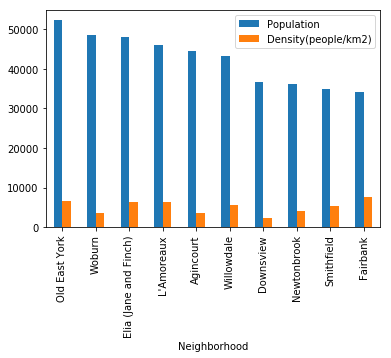

In [172]:
## Draw some bar graph for preliminlary analysis.

tor_popultaion = table_demo_df_3[['Population','Density(people/km2)']]
## Choose the first 10 neighborhoods with most population
tor_popultaion = tor_popultaion.sort_values(by = 'Population', ascending = False).iloc[0:10, :]
ax = tor_popultaion.plot(kind='bar')
ax

In [173]:
tor_popultaion.head()

,Population,Density(people/km2)
Neighborhood,,
Old East York,52220.0,6577.0
Woburn,48507.0,3636.0
Elia (Jane and Finch),48003.0,6267.0
L'Amoreaux,45862.0,6414.0
Agincourt,44577.0,3580.0


In [150]:
table_demo_df_3.columns

Index(['Population', 'Density(people/km2)', 'Average Income',
       'Percent of Renters', 'Latitude', 'Longitude', 'Total_Restaurant',
       'Ratio_of_Chinese_Restaurants', 'Total_num_venues'],
      dtype='object')

C:\TEXTBOOK\Python\anoconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


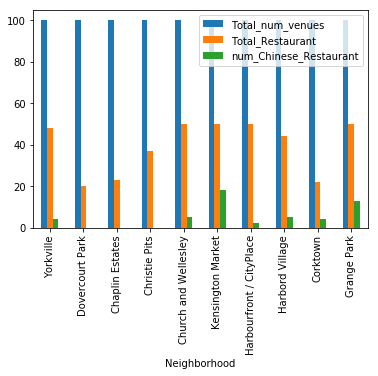

In [151]:
tor_ven = table_demo_df_3[['Total_num_venues', 'Total_Restaurant']]
tor_ven['num_Chinese_Restaurant'] = table_demo_df_3['Total_Restaurant']*table_demo_df_3['Ratio_of_Chinese_Restaurants']
tor_ven = tor_ven.sort_values(by = 'Total_num_venues', ascending = False).iloc[0:10, :]
ax1 = tor_ven.plot(kind='bar')
ax1

In [176]:
tor_ven.head()

,Total_num_venues,Total_Restaurant,num_Chinese_Restaurant
Neighborhood,,,
Yorkville,100.0,48.0,4.0
Dovercourt Park,100.0,20.0,0.0
Chaplin Estates,100.0,23.0,0.0
Christie Pits,100.0,37.0,0.0
Church and Wellesley,100.0,50.0,5.0


It seems like that the park and market has large numbers of resturants.

## Clustering

In [162]:
## Us k-means clustering 
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler 

In [165]:
cluster_table = table_demo_df_3[['Population', 'Density(people/km2)', 'Average Income',
       'Percent of Renters', 'Total_Restaurant',
       'Ratio_of_Chinese_Restaurants', 'Total_num_venues']]
x = StandardScaler().fit_transform(cluster_table)
type(x)

numpy.ndarray

In [170]:
clusterNum = 8
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(x)
labels = k_means.labels_
print(labels)

[5 1 0 2 6 1 6 4 1 1 1 5 1 1 3 6 3 0 3 3 3 0 4 1 7 7 3 3 1 3 3 3 0 3 6 5 1
 3 5 3 1 6 1 6 7 7 5 0 0 6 6 3 0 6 0 6 1 0 0 1 1 6 1 7 2 6 1 1 1 1 1 6 6 3
 0 6 1 5 1 3 6 2 1 1 3 0 3 6 2 6 1 7 1 2 1 6 6 5 0 4 6 6 5 1 6 3 6 1 3 1 1
 0 3 0 5 5 1 3 2 1 5 6 6 0 7 5 3 4 7 0 6 1 7 0 3 3 1 3 1 1 6 6 0 3 6 3 7 5
 6 6 6 6 5 6 5 3 1 5 0]


In [171]:
table_demo_df_3['Cluster'] = labels
table_demo_df_3.head()

,Population,Density(people/km2),Average Income,Percent of Renters,Latitude,Longitude,Total_Restaurant,Ratio_of_Chinese_Restaurants,Total_num_venues,Cluster
Neighborhood,,,,,,,,,,
Agincourt,44577.0,3580.0,25750.0,5.9,43.785353,-79.278549,34.0,0.323529,35.0,5
Alderwood,11656.0,2360.0,35239.0,8.5,43.601717,-79.545232,2.0,0.000000,22.0,1
Alexandra Park,4355.0,13609.0,19687.0,28.0,43.650758,-79.404298,50.0,0.260000,100.0,0
Allenby,2513.0,4333.0,245592.0,3.4,43.711351,-79.553424,3.0,0.000000,24.0,2
Amesbury,17318.0,4934.0,27546.0,19.7,43.706162,-79.483492,1.0,0.000000,25.0,6


In [175]:
table_demo_df_3.loc['Old East York','Cluster' ]

5

In [177]:
table_demo_df_3.loc['Yorkville','Cluster' ]

0

In [178]:
table_demo_df_3.loc['Yorkville' ]

Population                        6045.000000
Density(people/km2)              10795.000000
Average Income                  105239.000000
Percent of Renters                  27.900000
Latitude                            43.671386
Longitude                          -79.390168
Total_Restaurant                    48.000000
Ratio_of_Chinese_Restaurants         0.083333
Total_num_venues                   100.000000
Cluster                              0.000000
Name: Yorkville, dtype: float64

### We can see that, cluster 5 have high population, high density, and high number of venues. The ratio of Chinese restaurant is relaively low.

In [180]:
# Draw a folium map
# create map
map_clusters = folium.Map(location=[43.741667, -79.373333], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(table_demo_df_3['Latitude'], table_demo_df_3['Longitude'], table_demo_df_3.index, table_demo_df_3['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [182]:
print("Neighborhoods need to be investigate at first is:\n", table_demo_df_3.index[table_demo_df_3['Cluster'] == 5])

Neighborhoods need to be investigate at first is:
 Index(['Agincourt', 'Bendale', 'Don Valley Village', 'Downsview', 'Fairbank',
       'L'Amoreaux', 'Newtonbrook', 'Old East York', 'Richview', 'Riverdale',
       'Scarborough Junction', 'Smithfield', 'West Hill', 'Willowdale',
       'Woburn', 'York University Heights'],
      dtype='object', name='Neighborhood')


In [184]:
table_demo_df_3.loc['Newtonbrook']

Population                      36046.000000
Density(people/km2)              4110.000000
Average Income                  33428.000000
Percent of Renters                 14.300000
Latitude                           43.793886
Longitude                         -79.425679
Total_Restaurant                   22.000000
Ratio_of_Chinese_Restaurants        0.000000
Total_num_venues                   83.000000
Cluster                             5.000000
Name: Newtonbrook, dtype: float64

In [185]:
table_demo_df_3.shape

(159, 10)